# Comparative Analysis: Cascade vs QC-LDPCv2
## BB84 QKD Reconciliation Protocols

This notebook provides a detailed comparison between two major reconciliation protocols used in Quantum Key Distribution:
1.  **Cascade**: An interactive, multi-pass protocol based on binary search.
2.  **QC-LDPCv2**: A modern, forward-error-correction style protocol using Quasi-Cyclic Low-Density Parity-Check codes (implemented via `ldpc` v2 library).

We evaluate them based on:
*   **Leakage**: How much key material is sacrificed.
*   **Efficiency**: Proximity to the Shannon Limit.
*   **Latency**: Number of network round-trips required.
*   **Speed**: Computational execution time.

In [10]:
import asyncio
import random
import sys
import os
import math
import time
import matplotlib.pyplot as plt
import numpy as np

# Ensure we can import from the ServerClientBB84 directory
current_dir = os.getcwd()
target_dir = os.path.join(current_dir, 'ServerClientBB84')
if target_dir not in sys.path:
    sys.path.append(target_dir)

try:
    from bb84_server_client import AliceServer, BobClient, QuantumChannel, Detector, Eve, APIClient
except ImportError:
    # Fallback for relative paths if notebook is inside the folder
    sys.path.append(os.getcwd())
    from bb84_server_client import AliceServer, BobClient, QuantumChannel, Detector, Eve, APIClient

# Enable inline plotting
%matplotlib inline

print("Libraries imported successfully.")

Libraries imported successfully.


In [11]:
async def run_comparison_simulation(protocol="cascade", 
                                    num_qubits=5000, 
                                    optical_error_rate=0.01,
                                    verbose=False):
    """
    Runs a single BB84 simulation using the specified reconciliation protocol.
    Args:
        protocol (str): "cascade" or "ldpc"
        num_qubits (int): input block size
        optical_error_rate (float): simulated channel error
    """
    seed_base = 33
    
    # 1. Setup Quantum Channel
    # We use next_actor=None initially and link later
    channel = QuantumChannel("Fiber", length_km=50, attenuation_db=0.2, 
                             optical_error_rate=optical_error_rate, next_actor=None, seed=seed_base)
    
    # 2. Setup Alice & API
    alice = AliceServer("Alice", channel, num_qubits=num_qubits, verbose=verbose, seed=seed_base+1)
    api = APIClient(alice)
    
    # 3. Setup Bob with Specific Protocol
    bob = BobClient("Bob", api, protocol=protocol, seed=seed_base+2, verbose=verbose)
    
    # 4. Setup Detector (needs parent Bob)
    detector = Detector("Detector", efficiency=0.8, dark_count_prob=0.01, parent_bob=bob, seed=seed_base+3)

    # 5. Setup Eve (Always included as per request)
    # Wiring: Channel -> Eve -> Detector -> Bob
    eve = Eve("Eve", next_actor=detector, intercept_rate=0.2, seed=seed_base+5)
    channel.next_actor = eve
    
    actors = [alice, channel, eve, detector, bob]
    tasks = [asyncio.create_task(a.start()) for a in actors]
    
    results = {}
    try:
        # Phase 1: Transmission
        await alice.run_quantum_transmission()
        
        # Wait for propagation (heuristic)
        wait_time = 0.5 + (num_qubits * 0.0001)
        await asyncio.sleep(wait_time)
        
        # Phase 2: Post-Processing
        results = await bob.run_classical_post_processing(num_qubits)
        
    except Exception as e:
        print(f"Error in {protocol} sim: {e}")
    finally:
        for a in actors:
            await a.send(a, ("STOP",))
        await asyncio.gather(*tasks)
        
    return results

print("Simulation driver defined.")

Simulation driver defined.


In [12]:
def binary_entropy(p):
    """Calculates binary entropy H(p)."""
    if p <= 0 or p >= 1: return 0.0
    return -p * math.log2(p) - (1 - p) * math.log2(1 - p)

def calculate_efficiency(n_revealed, k_sifted, qber):
    """
    Calculates Reconciliation Efficiency eta.
    eta = N_revealed / (K_sifted * H(QBER))
    Ideal = 1.0. Lower is better? No, standard def says eta >= 1. 
    Ideally N_revealed = N_sifted * H(QBER). So eta = 1 is perfect.
    Efficiency usually > 1, meaning we revealed more than theoretical minimum.
    """
    if k_sifted == 0 or qber <= 0 or qber >= 1:
        return None
    
    h_eps = binary_entropy(qber)
    if h_eps == 0: return None
    
    return n_revealed / (k_sifted * h_eps)

print("Metric functions defined.")

Metric functions defined.


In [13]:
# --- Experiment 1: Impact of QBER ---

error_rates = np.linspace(0.001, 0.15, 50)  # Sweep from 1% to 12%
# Note: QC-LDPC typically performs well up to a threshold, while Cascade degrades linearly.

results_cascade = {"qber": [], "leakage": [], "efficiency": [], "uses": []}
results_ldpc = {"qber": [], "leakage": [], "efficiency": [], "uses": [], 'res_l': []}

N_QUBITS = 50000

print(f"Running QBER Sweep (N={N_QUBITS})...")

for err in error_rates:
    print(f"Testing Optical Error: {err:.3f}...")
    
    # Run Cascade
    res_c = await run_comparison_simulation("cascade", N_QUBITS, err)
    if res_c.get('sifted_length', 0) > 0 and res_c.get('qber', 0) > 0:
        # Use final_length (actual bits reconciled) instead of sifted_length (which includes discarded sample bits)
        # This standardizes the efficiency metric to the bits actually processed.
        eff = calculate_efficiency(res_c['revealed'], res_c['final_length'], res_c['qber'])
        if eff:
            results_cascade["qber"].append(res_c['qber'] * 100) # %
            results_cascade["leakage"].append((res_c['revealed'] / res_c['final_length']) * 100)
            results_cascade["efficiency"].append(eff)
            results_cascade["uses"].append(res_c['channel_uses'])

    # Run LDPC (v2)
    res_l = await run_comparison_simulation("ldpcv2", N_QUBITS, err)
    if res_l.get('sifted_length', 0) > 0 and res_l.get('qber', 0) > 0:
        # Correct efficiency calculation: Denominator should be based on Reconciled Key Length (final_length)
        eff = calculate_efficiency(res_l['revealed'], res_l['final_length'], res_l['qber'])
        if eff:
            results_ldpc["qber"].append(res_l['qber'] * 100)
            results_ldpc["leakage"].append((res_l['revealed'] / res_l['final_length']) * 100)
            results_ldpc["efficiency"].append(eff)
            results_ldpc["uses"].append(res_l['channel_uses'])
            results_ldpc["res_l"].append(res_l)

print("Experiment 1 Complete.")

Running QBER Sweep (N=50000)...
Testing Optical Error: 0.001...

[BOB] Processing 4036 detection events.
[BOB] First 15 Valid Detections: 0(+), 0(x), 1(x), 1(x), 1(+), 0(+), 0(x), 1(x), 1(+), 0(x), 1(x), 1(+), 1(+), 0(+), 1(+) ...
[BOB] Sending 4036 bases to Alice for sifting...
[BOB] Sifting complete. Bases matched on 2004 events.
[BOB] Sifted Key Preview: [0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1]...
[BOB] Sampling 400 bits for QBER estimation...
[BOB] QBER Analysis: 22 errors in 400 samples. Estimated QBER = 5.50%
[BOB] Discarding revealed bits. Working Key Size: 1604
[BOB] Initializing Cascade Protocol...

[BOB] Processing 4036 detection events.
[BOB] First 15 Valid Detections: 0(+), 0(x), 1(x), 1(x), 1(+), 0(+), 0(x), 1(x), 1(+), 0(x), 1(x), 1(+), 1(+), 0(+), 1(+) ...
[BOB] Sending 4036 bases to Alice for sifting...
[BOB] Sifting complete. Bases matched on 2004 events.
[BOB] Sifted Key Preview: [0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1]...
[BOB]

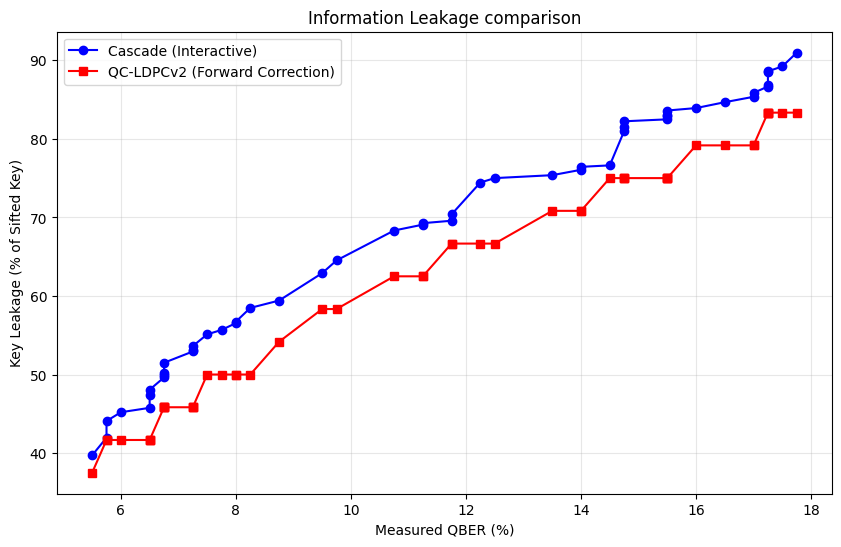

In [14]:
# --- Graph 1: Key Leakage vs QBER ---

plt.figure(figsize=(10, 6))

# Sort data for clean plotting
if len(results_cascade["qber"]) > 0:
    idx_c = np.argsort(results_cascade["qber"])
    plt.plot(np.array(results_cascade["qber"])[idx_c], 
             np.array(results_cascade["leakage"])[idx_c], 
             'o-', color='blue', label='Cascade (Interactive)')

if len(results_ldpc["qber"]) > 0:
    idx_l = np.argsort(results_ldpc["qber"])
    plt.plot(np.array(results_ldpc["qber"])[idx_l], 
             np.array(results_ldpc["leakage"])[idx_l], 
             's-', color='red', label='QC-LDPCv2 (Forward Correction)')

plt.xlabel('Measured QBER (%)')
plt.ylabel('Key Leakage (% of Sifted Key)')
plt.title('Information Leakage comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

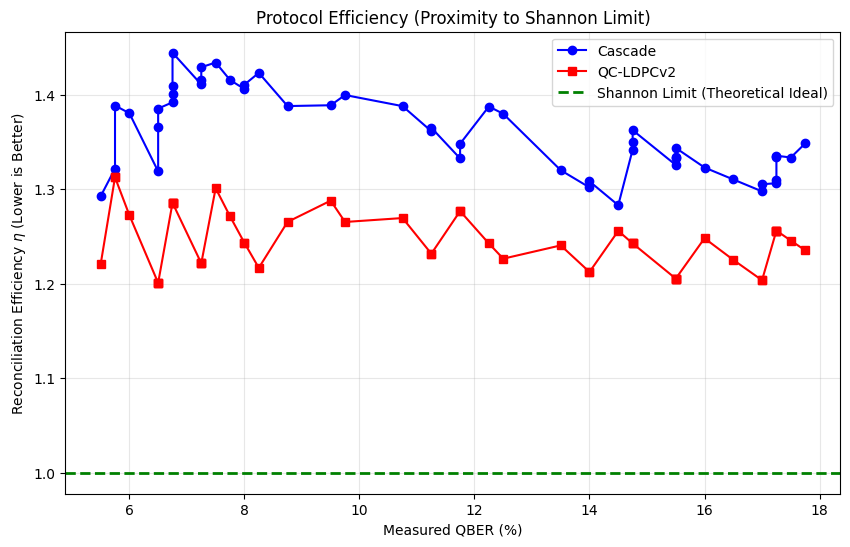

In [15]:
# --- Graph 2: Reconciliation Efficiency vs QBER ---

plt.figure(figsize=(10, 6))

if len(results_cascade["qber"]) > 0:
    idx_c = np.argsort(results_cascade["qber"])
    plt.plot(np.array(results_cascade["qber"])[idx_c], 
             np.array(results_cascade["efficiency"])[idx_c], 
             'o-', color='blue', label='Cascade')

if len(results_ldpc["qber"]) > 0:
    idx_l = np.argsort(results_ldpc["qber"])
    plt.plot(np.array(results_ldpc["qber"])[idx_l], 
             np.array(results_ldpc["efficiency"])[idx_l], 
             's-', color='red', label='QC-LDPCv2')

plt.axhline(y=1.0, color='green', linestyle='--', linewidth=2, label='Shannon Limit (Theoretical Ideal)')

plt.xlabel('Measured QBER (%)')
plt.ylabel(r'Reconciliation Efficiency $\eta$ (Lower is Better)')
plt.title('Protocol Efficiency (Proximity to Shannon Limit)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

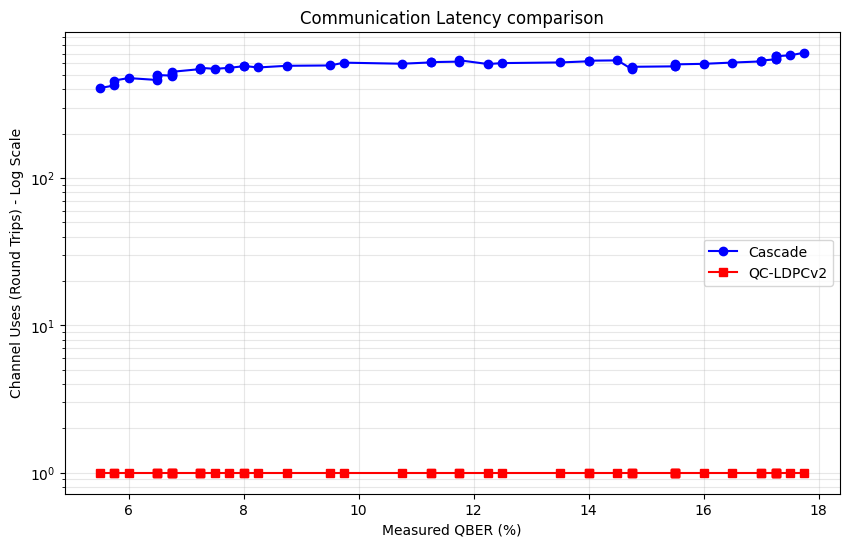

In [16]:
# --- Graph 3: Latency (Round Trips) vs QBER ---

plt.figure(figsize=(10, 6))

if len(results_cascade["qber"]) > 0:
    idx_c = np.argsort(results_cascade["qber"])
    plt.plot(np.array(results_cascade["qber"])[idx_c], 
             np.array(results_cascade["uses"])[idx_c], 
             'o-', color='blue', label='Cascade')

if len(results_ldpc["qber"]) > 0:
    idx_l = np.argsort(results_ldpc["qber"])
    plt.plot(np.array(results_ldpc["qber"])[idx_l], 
             np.array(results_ldpc["uses"])[idx_l], 
             's-', color='red', label='QC-LDPCv2')

plt.yscale('log')
plt.xlabel('Measured QBER (%)')
plt.ylabel('Channel Uses (Round Trips) - Log Scale')
plt.title('Communication Latency comparison')
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()

In [17]:
# --- Experiment 2: Computation Time vs Block Size ---

block_sizes = [1000, 2500, 5000, 10000, 20000, 50000]
time_cascade = []
time_ldpc = []

FIXED_ERR = 0.02 # 2% error

print(f"Running Scalability Test (Error={FIXED_ERR})...")

for size in block_sizes:
    print(f"Testing Block Size: {size}...", end="\r")
    
    # Cascade
    res_c = await run_comparison_simulation("cascade", size, FIXED_ERR)
    time_cascade.append(res_c.get("exec_time", 0))
    
    # LDPC (v2)
    res_l = await run_comparison_simulation("ldpcv2", size, FIXED_ERR)
    time_ldpc.append(res_l.get("exec_time", 0))

print("\nScalability Experiment Complete.")

Running Scalability Test (Error=0.02)...
Testing Block Size: 1000...
[BOB] Processing 83 detection events.
[BOB] First 15 Valid Detections: 0(+), 0(x), 1(x), 1(x), 1(+), 0(+), 0(x), 1(x), 1(+), 1(x), 1(x), 1(+), 1(+), 0(+), 1(+) ...
[BOB] Sending 83 bases to Alice for sifting...
[BOB] Sifting complete. Bases matched on 40 events.
[BOB] Sifted Key Preview: [0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1]...
[BOB] Adjusted sample size to minimum 10 bits.
[BOB] Sampling 10 bits for QBER estimation...
[BOB] QBER Analysis: 1 errors in 10 samples. Estimated QBER = 10.00%
[BOB] Discarding revealed bits. Working Key Size: 30
[BOB] Initializing Cascade Protocol...

[BOB] Processing 83 detection events.
[BOB] First 15 Valid Detections: 0(+), 0(x), 1(x), 1(x), 1(+), 0(+), 0(x), 1(x), 1(+), 1(x), 1(x), 1(+), 1(+), 0(+), 1(+) ...
[BOB] Sending 83 bases to Alice for sifting...
[BOB] Sifting complete. Bases matched on 40 events.
[BOB] Sifted Key Preview: [0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 

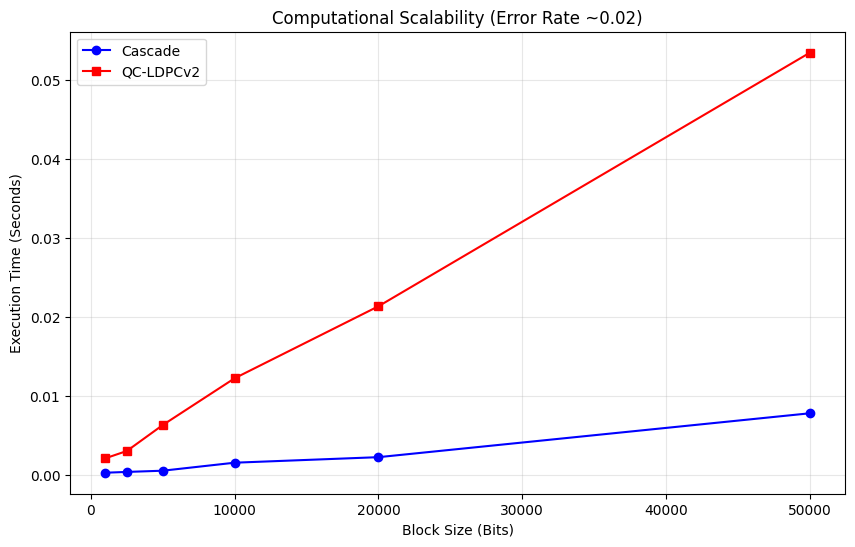

In [18]:
# --- Graph 4: Execution Time vs Block Size ---

plt.figure(figsize=(10, 6))

plt.plot(block_sizes, time_cascade, 'o-', color='blue', label='Cascade')
plt.plot(block_sizes, time_ldpc, 's-', color='red', label='QC-LDPCv2')

plt.xlabel('Block Size (Bits)')
plt.ylabel('Execution Time (Seconds)')
plt.title(f'Computational Scalability (Error Rate ~{FIXED_ERR})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()